In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
#change the tickers here according to what's in the portfolio
tickers = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [3]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ETR     1259 non-null   float64
 1   AMD     1259 non-null   float64
 2   EPAM    1259 non-null   float64
 3   ASML    1259 non-null   float64
 4   AUDC    1259 non-null   float64
 5   DSGX    1259 non-null   float64
 6   MGIC    1259 non-null   float64
 7   RDWR    1259 non-null   float64
 8   IDXX    1259 non-null   float64
 9   IQV     1259 non-null   float64
 10  BDSI    1259 non-null   float64
 11  ICLR    1259 non-null   float64
 12  MEDP    1259 non-null   float64
 13  MODV    1259 non-null   float64
 14  RGEN    1259 non-null   float64
 15  TROW    1259 non-null   float64
 16  CG      1259 non-null   float64
 17  CSWC    1259 non-null   float64
 18  TBBK    1259 non-null   float64
 19  CBRE    1259 non-null   float64
 20  SBAC    1259 non-null   float64
 21  ^FVX    1259 non-nu

## Function that saves dataframe to CSV

In [4]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [5]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Adj Close']
    save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [6]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [7]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [8]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [9]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [10]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [11]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [12]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [13]:
#change to the list of stocks we using
port_list = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX']

#add in the weightage of stocks
port_shares = [0.08,0.0068514,0.0147378,0.0159702,0.0095448,
               0.0088422,0.0034434,0.0006096,0.0206544,0.0006252,
               0.0041838,0.003777,0.0048612,0.005601,0.0202974,
               0.02456,0.031718,0.021091,0.022631,0.03152,0.06848,
               0.6]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,4.742889,0.078312,0.938208,1.683688,0.058643,0.187897,0.021305,0.008949,2.428957,0.048097,...,0.632264,1.590487,0.387854,0.269079,0.182406,0.995086,7.089792,1.1664,23.189291,NaN
2017-01-04,4.763697,0.078312,0.948525,1.675609,0.057932,0.189665,0.021459,0.008998,2.394878,0.048315,...,0.655606,1.614186,0.399043,0.275666,0.171996,1.011162,7.099869,1.1682,23.278052,0.003828
2017-01-05,4.746792,0.077010,0.954273,1.695731,0.055974,0.187013,0.021614,0.008955,2.395084,0.048140,...,0.672047,1.601603,0.405258,0.275336,0.162491,1.002651,7.005813,1.1178,23.122904,-0.006665
2017-01-06,4.762397,0.077558,0.985517,1.693902,0.057042,0.187897,0.021459,0.008931,2.444655,0.048653,...,0.671844,1.585874,0.413960,0.271713,0.162264,0.983424,6.954753,1.1532,23.185140,0.002692
2017-01-09,4.622594,0.078723,0.985074,1.714786,0.056152,0.187455,0.021459,0.008839,2.458287,0.048759,...,0.656418,1.527363,0.415203,0.275336,0.160680,0.981218,6.919148,1.1286,22.950368,-0.010126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,8.786064,1.057582,10.272247,12.958699,0.332636,0.723469,0.073723,0.024884,13.525328,0.176344,...,5.436861,4.852210,1.771535,0.518406,0.574601,3.397541,26.195123,0.7512,94.557691,0.020424
2021-12-28,8.870095,1.049292,10.054127,12.852338,0.330346,0.725060,0.072552,0.024646,13.451798,0.175437,...,5.150871,4.854401,1.750081,0.517166,0.566907,3.395334,26.288736,0.7470,93.946389,-0.006465
2021-12-29,8.917661,1.015789,9.989871,12.807781,0.332255,0.728951,0.072690,0.025280,13.542884,0.176456,...,5.234699,4.808878,1.715375,0.514480,0.577317,3.422442,26.303770,0.7764,94.052357,0.001128


## Get old data for portfolio

In [14]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,4.742889,0.078312,0.938208,1.683688,0.058643,0.187897,0.021305,0.008949,2.428957,0.048097,...,0.632264,1.590487,0.387854,0.269079,0.182406,0.995086,7.089792,1.1664,23.189291,NaN
2017-01-04,4.763697,0.078312,0.948525,1.675609,0.057932,0.189665,0.021459,0.008998,2.394878,0.048315,...,0.655606,1.614186,0.399043,0.275666,0.171996,1.011162,7.099869,1.1682,23.278052,0.003828
2017-01-05,4.746792,0.077010,0.954273,1.695731,0.055974,0.187013,0.021614,0.008955,2.395084,0.048140,...,0.672047,1.601603,0.405258,0.275336,0.162491,1.002651,7.005813,1.1178,23.122904,-0.006665
2017-01-06,4.762397,0.077558,0.985517,1.693902,0.057042,0.187897,0.021459,0.008931,2.444655,0.048653,...,0.671844,1.585874,0.413960,0.271713,0.162264,0.983424,6.954753,1.1532,23.185140,0.002692
2017-01-09,4.622594,0.078723,0.985074,1.714786,0.056152,0.187455,0.021459,0.008839,2.458287,0.048759,...,0.656418,1.527363,0.415203,0.275336,0.160680,0.981218,6.919148,1.1286,22.950368,-0.010126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,8.786064,1.057582,10.272247,12.958699,0.332636,0.723469,0.073723,0.024884,13.525328,0.176344,...,5.436861,4.852210,1.771535,0.518406,0.574601,3.397541,26.195123,0.7512,94.557691,0.020424
2021-12-28,8.870095,1.049292,10.054127,12.852338,0.330346,0.725060,0.072552,0.024646,13.451798,0.175437,...,5.150871,4.854401,1.750081,0.517166,0.566907,3.395334,26.288736,0.7470,93.946389,-0.006465
2021-12-29,8.917661,1.015789,9.989871,12.807781,0.332255,0.728951,0.072690,0.025280,13.542884,0.176456,...,5.234699,4.808878,1.715375,0.514480,0.577317,3.422442,26.303770,0.7764,94.052357,0.001128


## Forecasting

In [15]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [16]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [17]:
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,4.742889,0.078312,0.938208,1.683688,0.058643,0.187897,0.021305,0.008949,2.428957,0.048097,...,0.632264,1.590487,0.387854,0.269079,0.182406,0.995086,7.089792,1.1664,23.189291,NaN
2017-01-04,4.763697,0.078312,0.948525,1.675609,0.057932,0.189665,0.021459,0.008998,2.394878,0.048315,...,0.655606,1.614186,0.399043,0.275666,0.171996,1.011162,7.099869,1.1682,23.278052,0.003828
2017-01-05,4.746792,0.077010,0.954273,1.695731,0.055974,0.187013,0.021614,0.008955,2.395084,0.048140,...,0.672047,1.601603,0.405258,0.275336,0.162491,1.002651,7.005813,1.1178,23.122904,-0.006665
2017-01-06,4.762397,0.077558,0.985517,1.693902,0.057042,0.187897,0.021459,0.008931,2.444655,0.048653,...,0.671844,1.585874,0.413960,0.271713,0.162264,0.983424,6.954753,1.1532,23.185140,0.002692
2017-01-07,4.762397,0.077558,0.985517,1.693902,0.057042,0.187897,0.021459,0.008931,2.444655,0.048653,...,0.671844,1.585874,0.413960,0.271713,0.162264,0.983424,6.954753,1.1532,23.185140,0.002692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,8.786064,1.057582,10.272247,12.958699,0.332636,0.723469,0.073723,0.024884,13.525328,0.176344,...,5.436861,4.852210,1.771535,0.518406,0.574601,3.397541,26.195123,0.7512,94.557691,0.020424
2021-12-28,8.870095,1.049292,10.054127,12.852338,0.330346,0.725060,0.072552,0.024646,13.451798,0.175437,...,5.150871,4.854401,1.750081,0.517166,0.566907,3.395334,26.288736,0.7470,93.946389,-0.006465
2021-12-29,8.917661,1.015789,9.989871,12.807781,0.332255,0.728951,0.072690,0.025280,13.542884,0.176456,...,5.234699,4.808878,1.715375,0.514480,0.577317,3.422442,26.303770,0.7764,94.052357,0.001128


In [18]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [19]:
tot_port_df

,Total
Date,
2017-01-03,23.189291
2017-01-04,23.278052
2017-01-05,23.122904
2017-01-06,23.185140
2017-01-07,23.185140
...,...
2021-12-27,94.557691
2021-12-28,93.946389
2021-12-29,94.052357


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1824


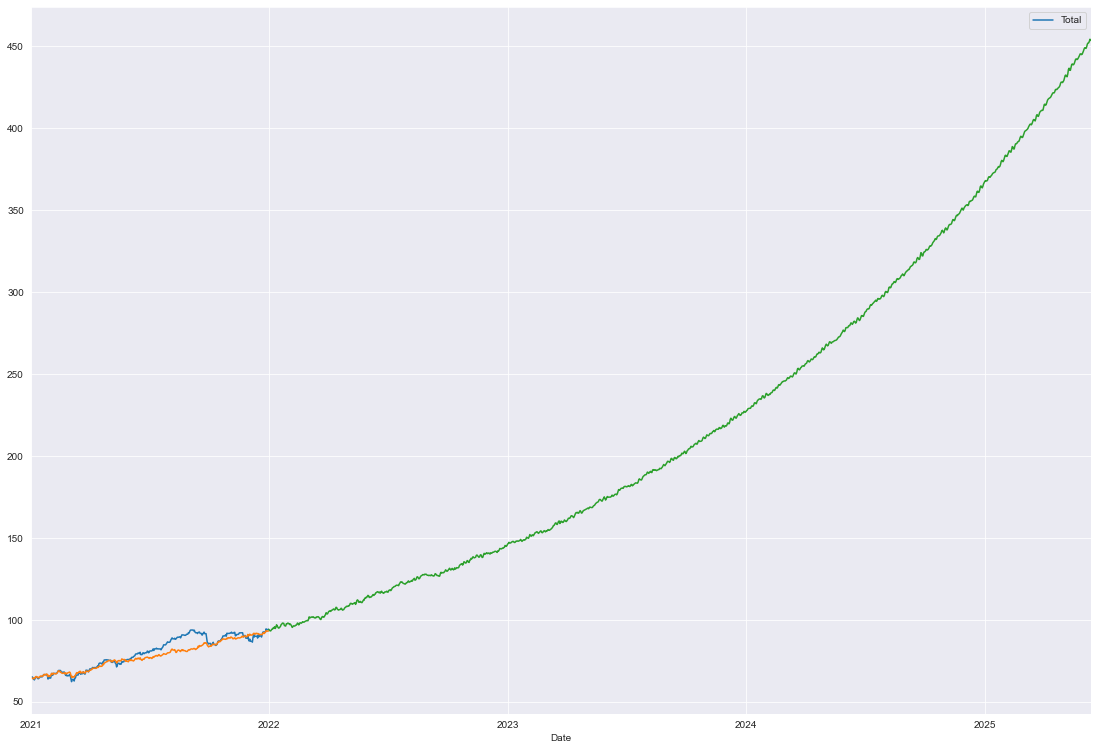

In [20]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [21]:
forecast

2021-12-31     94.235594
2022-01-01     93.769456
2022-01-02     93.398389
2022-01-03     93.292358
2022-01-04     93.903821
                 ...    
2025-06-09    451.987870
2025-06-10    452.937349
2025-06-11    454.235058
2025-06-12    453.521263
2025-06-13    453.439203
Freq: D, Length: 1261, dtype: float64

In [22]:
forecast_df = pd.DataFrame(forecast)

In [23]:
forecast_df

,0
2021-12-31,94.235594
2022-01-01,93.769456
2022-01-02,93.398389
2022-01-03,93.292358
2022-01-04,93.903821
...,...
2025-06-09,451.987870
2025-06-10,452.937349
2025-06-11,454.235058
2025-06-12,453.521263


In [24]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [25]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.004947
2022-01-02,-0.008884
2022-01-03,-0.010009
2022-01-04,-0.003521
...,...
2025-06-09,3.796360
2025-06-10,3.806436
2025-06-11,3.820207
2025-06-12,3.812632


In [26]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1/5))-1

print(annualized_return*100)

                    0
2025-06-13  36.918086
